# Dealing With Imbalanced Data: Wisconsin Breast Cancer Dataset

In [122]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Load Data

The breast cancer dataset is from [https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)]. The data set has 10 attributes and 699 instances.

Attribute Information:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

In [123]:
!ls

breast-cancer-wisconsin.data           notebooks
breast-cancer-wisconsin_describe.names requirements.txt
imbalanced_data.ipynb                  venv


In [124]:
ds = pd.read_csv('breast-cancer-wisconsin.data', header=None, index_col=0)

In [125]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
1     699 non-null int64
2     699 non-null int64
3     699 non-null int64
4     699 non-null int64
5     699 non-null int64
6     699 non-null object
7     699 non-null int64
8     699 non-null int64
9     699 non-null int64
10    699 non-null int64
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


## Class Imbalance

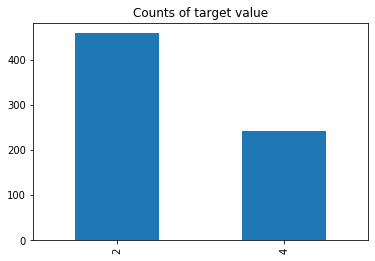

In [126]:
ds[10].value_counts().plot.bar(title='Counts of target value')

## Preprocess Data

###  Missing Values
There are missing values in the 6th column. 

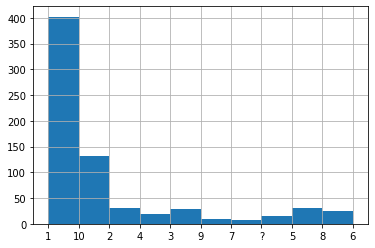

In [127]:
ds[6].hist()

The values of the 6th column are not normally distributed. Therefore we won't impute the missing values, but drop the columns. Another possibility would be to fill in the most frequent value, 1. 

In [128]:
len(ds[ds[6] == '?'])

16

In [129]:
ds = ds[ds[6] != '?']

In [130]:
len(ds)

683

The last column is our target column.

In [131]:
X = ds.iloc[:, : -1].values
X

array([[5, 1, 1, ..., 3, 1, 1],
       [5, 4, 4, ..., 3, 2, 1],
       [3, 1, 1, ..., 3, 1, 1],
       ...,
       [5, 10, 10, ..., 8, 10, 2],
       [4, 8, 6, ..., 10, 6, 1],
       [4, 8, 8, ..., 10, 4, 1]], dtype=object)

In [132]:
y = ds.iloc[:, -1].values

## Target Vector to Binary Vector

We convert the target vector to binaries, 0 and 1: 2 -> Class 0, 4 -> Class 1


In [133]:
y = np.array([int(a == 4) for a in y])

In [134]:
X

array([[5, 1, 1, ..., 3, 1, 1],
       [5, 4, 4, ..., 3, 2, 1],
       [3, 1, 1, ..., 3, 1, 1],
       ...,
       [5, 10, 10, ..., 8, 10, 2],
       [4, 8, 6, ..., 10, 6, 1],
       [4, 8, 8, ..., 10, 4, 1]], dtype=object)

# Plot Data
To get a better feeling for the data, we reduce the data to two dimensions using tsne and plot the result.

In [135]:
from sklearn.manifold import TSNE

In [136]:
tsne = TSNE()

In [137]:
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = X_tsne[:, 0]
df_tsne['tsne-2d-two'] = X_tsne[:, 1]
df_tsne.head()

,tsne-2d-one,tsne-2d-two
0,1.069745,-2.142853
1,10.745806,18.828894
2,-9.933256,-1.964379
3,18.140657,8.861068
4,-6.733120,-7.470741


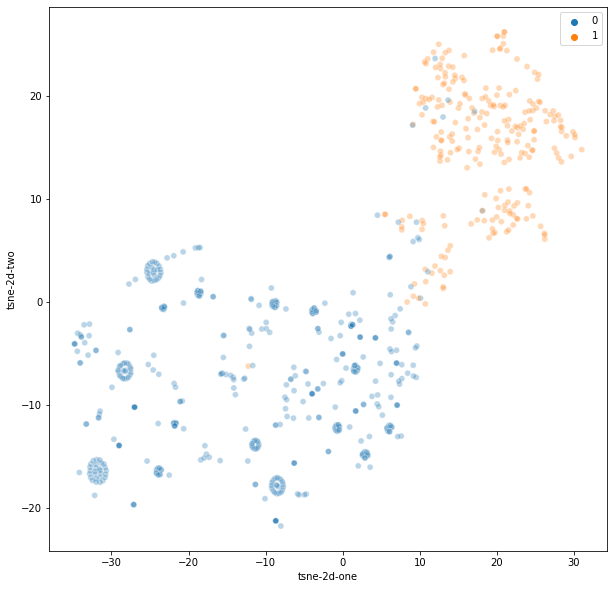

In [138]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data = df_tsne, legend="full", alpha=0.3, hue=y)

The data seems well separable.

# Create training, validation and test set

### Create training and test data set

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [140]:
print(len(X_train))

546


In [141]:
print(len(X_test))

137


### What does stratify do?
Stratify makes sure that there is roughly the same percentage of malicious and benign samples in the training and test set.

In [142]:
sum(y_train)/ len(y_train)

0.3498168498168498

In [143]:
sum(y_test) / len(y_test)

0.35036496350364965

In [144]:
sum(y) / len(y)

0.34992679355783307

### Create Validation Data Set from training data set.
The validation data set is used to compare different models' performance.

In [145]:
 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [146]:
len(y_val)

164

## Scale Data
Although all features here are on the same range between 0 and 10, and scaling therefore is not strictly necessary, we use MinMaxScaler to bring them all to a range between 0 and 1.

In [147]:
X_train

array([[2, 1, 1, ..., 2, 2, 1],
       [6, 3, 4, ..., 3, 9, 1],
       [5, 3, 3, ..., 4, 4, 1],
       ...,
       [4, 1, 1, ..., 3, 2, 1],
       [5, 8, 8, ..., 8, 10, 3],
       [5, 10, 10, ..., 8, 10, 2]], dtype=object)

In [148]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)
X_val = mms.transform(X_val)

## Optional: PCA

# Choose Metrics
The scores we are going to consider for this notebook are accuracy, f1, precision and recall. There are more metrics that can be suitable depending on the data set (e.g. roc-auc score, matthews_corr_coeff, see `Classification Metrics` in [https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics]). Accuracy will be printed out just for comparison. 

In [149]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report,confusion_matrix

The following function will print the confusion matrix and the different metrics for a classification result.

In [150]:
def get_report(y_test, y_pred):
    
    nr_y_test_malicious = sum(y_test)
    nr_y_test_benign = len(y_test) - sum(y_test)
    cfn_matrix = confusion_matrix(y_test,y_pred)
    cfn_norm_matrix = np.array([[1/ nr_y_test_benign,1/nr_y_test_benign],[1/nr_y_test_malicious,1/nr_y_test_malicious]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,y_pred))

## Classification
### Best Way: Get More Data

### Naive Classifier: Logistic Regression

In [151]:
from sklearn.linear_model import LogisticRegression

In [152]:
lr = LogisticRegression()

In [153]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)


In [154]:
sum(y_val)

57

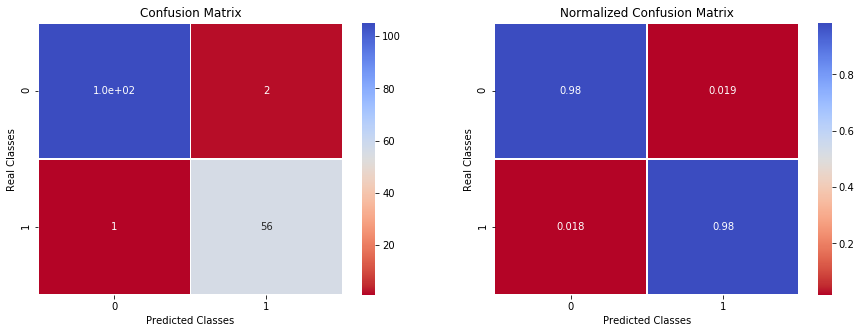

---Classification Report---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       107
           1       0.97      0.98      0.97        57

    accuracy                           0.98       164
   macro avg       0.98      0.98      0.98       164
weighted avg       0.98      0.98      0.98       164



In [155]:
get_report(y_val, y_pred)

### Random Forest

In [156]:
from sklearn.ensemble import RandomForestClassifier

In [157]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

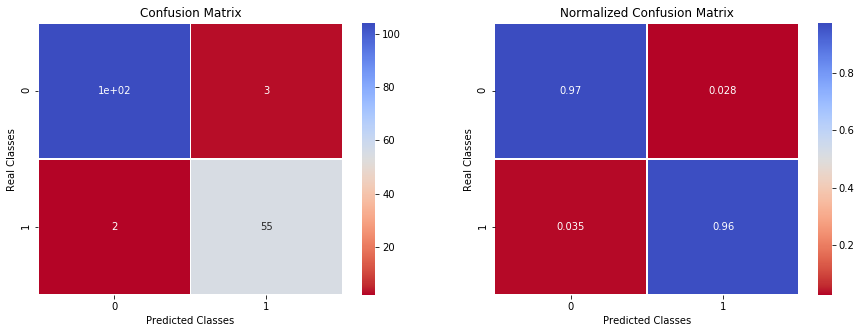

---Classification Report---
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       107
           1       0.95      0.96      0.96        57

    accuracy                           0.97       164
   macro avg       0.96      0.97      0.97       164
weighted avg       0.97      0.97      0.97       164



In [159]:
y_pred = rf.predict(X_val)
get_report(y_val, y_pred)

## Random Forest with Weighted Classes

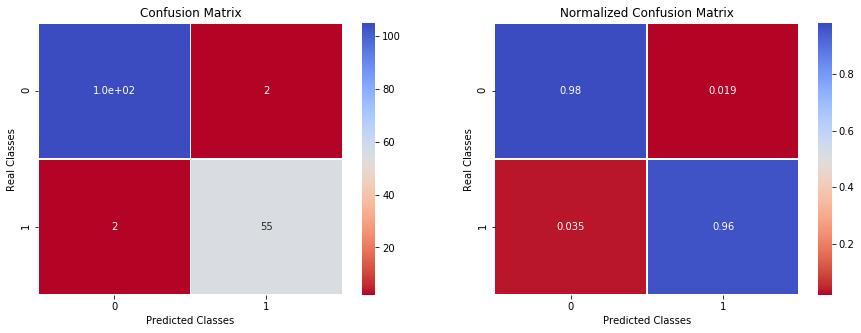

---Classification Report---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       107
           1       0.96      0.96      0.96        57

    accuracy                           0.98       164
   macro avg       0.97      0.97      0.97       164
weighted avg       0.98      0.98      0.98       164



In [160]:
rf2 = RandomForestClassifier(class_weight='balanced')
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_val)

get_report(y_val, y_pred)

Here: Weighted classes made the problem worse.

## Downsampling


In [171]:
from imblearn.under_sampling import NearMiss 


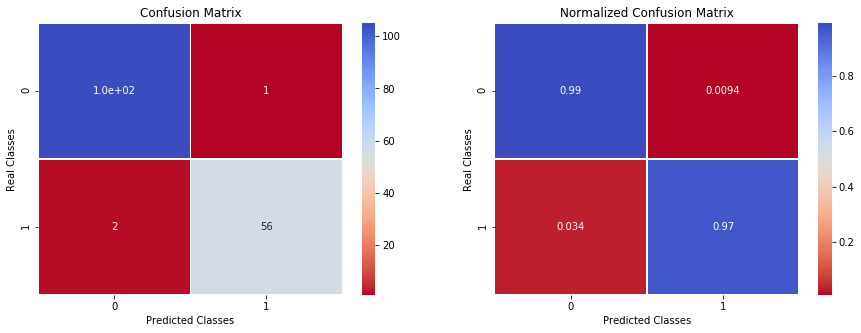

---Classification Report---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.98      0.97      0.97        58

    accuracy                           0.98       164
   macro avg       0.98      0.98      0.98       164
weighted avg       0.98      0.98      0.98       164



In [175]:
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X_train, y_train)
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_val)
get_report(y_pred, y_val)

## Upsampling: SMOTE

In [162]:
from imblearn.over_sampling import SMOTE

In [164]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

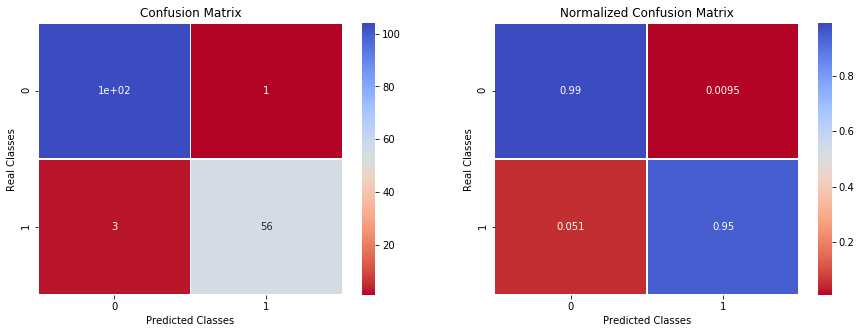

---Classification Report---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       105
           1       0.98      0.95      0.97        59

    accuracy                           0.98       164
   macro avg       0.98      0.97      0.97       164
weighted avg       0.98      0.98      0.98       164



In [169]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_val)
get_report(y_pred, y_val)

### Isolation Forest

In [176]:
from sklearn.ensemble import IsolationForest

In [178]:
iso = IsolationForest()

In [179]:
normal = X_train[y_train == 0]

In [180]:
len(X_train)

382

In [181]:
len(normal)

248

In [182]:
iso.fit(normal)

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [183]:
iso.predict(X_val)

array([-1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,
       -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,
        1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,
        1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,
        1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,
       -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1])

In [ ]:
# Best Classifier: Performance on Test set